## Getting Building Polygons

Using Open Street Map, this script extracts building polygons within the boundary of Kathmandu.

In [1]:
import geopandas as gpd
import requests
from shapely.geometry import box
import json
import os

To start, I will call in my boundary shapefile and the OSM data.

In [2]:
boundary_gdf = gpd.read_file("maincity.geojson")
    
minx, miny, maxx, maxy = boundary_gdf.total_bounds

In [3]:
# Overpass API query for buildings within the boundary box
overpass_url = "https://overpass-api.de/api/interpreter"

overpass_query = f"""
    [out:json];
    (
      way["building"]({miny},{minx},{maxy},{maxx});
      relation["building"]({miny},{minx},{maxy},{maxx});
    );
    out body;
    >;
    out skel qt;
    """

response = requests.get(overpass_url, params={"data": overpass_query})
  
data = response.json()

In [4]:
# Convert the data to GeoJSON format
nodes = {}
ways = []
relations = []
    
# Process nodes
for element in data['elements']:
    if element['type'] == 'node':
        nodes[element['id']] = (element['lon'], element['lat'])
    elif element['type'] == 'way' and 'nodes' in element:
        ways.append(element)
    elif element['type'] == 'relation':
        relations.append(element)

In [6]:
# Create features for ways
features = []

for way in ways:
    if 'nodes' in way and 'tags' in way and 'building' in way['tags']:
        # Get coordinates for nodes in this way
        try:
            coords = [nodes[node_id] for node_id in way['nodes']]
            # Close the polygon
            if way['nodes'][0] != way['nodes'][-1] and len(way['nodes']) >= 3:
                coords.append(coords[0])
                
            # Create the feature
            if len(coords) >= 4:  # Need at least 4 points for a valid polygon (3 + 1 closing)
                features.append({
                    "type": "Feature",
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [coords]
                    },
                    "properties": way['tags']
                })
        except KeyError:
            # Skip ways with missing nodes
            continue

In [7]:
import os
# Create the GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "features": features
}
    
# Save to file
output_file = "buildings.geojson"

with open(output_file, 'w') as f:
    json.dump(geojson, f)

In [8]:
buildings_gdf = gpd.read_file("buildings.geojson")

However, my data has many invalid geometries and self intersections. This is an issue so I will spend some time fixing this.

In [9]:
from shapely.validation import make_valid

buildings_gdf['geometry'] = buildings_gdf['geometry'].apply(lambda geom: make_valid(geom))

boundary_gdf['geometry'] = boundary_gdf['geometry'].apply(lambda geom: make_valid(geom))

In [10]:
# Filter out any None geometries
buildings_gdf = buildings_gdf[buildings_gdf['geometry'].notna()]
    
# Buffer by 0 to fix self-intersections and other topology issues
buildings_gdf['geometry'] = buildings_gdf['geometry'].buffer(0)
boundary_gdf['geometry'] = boundary_gdf['geometry'].buffer(0)

Plotting our values gives us the following.

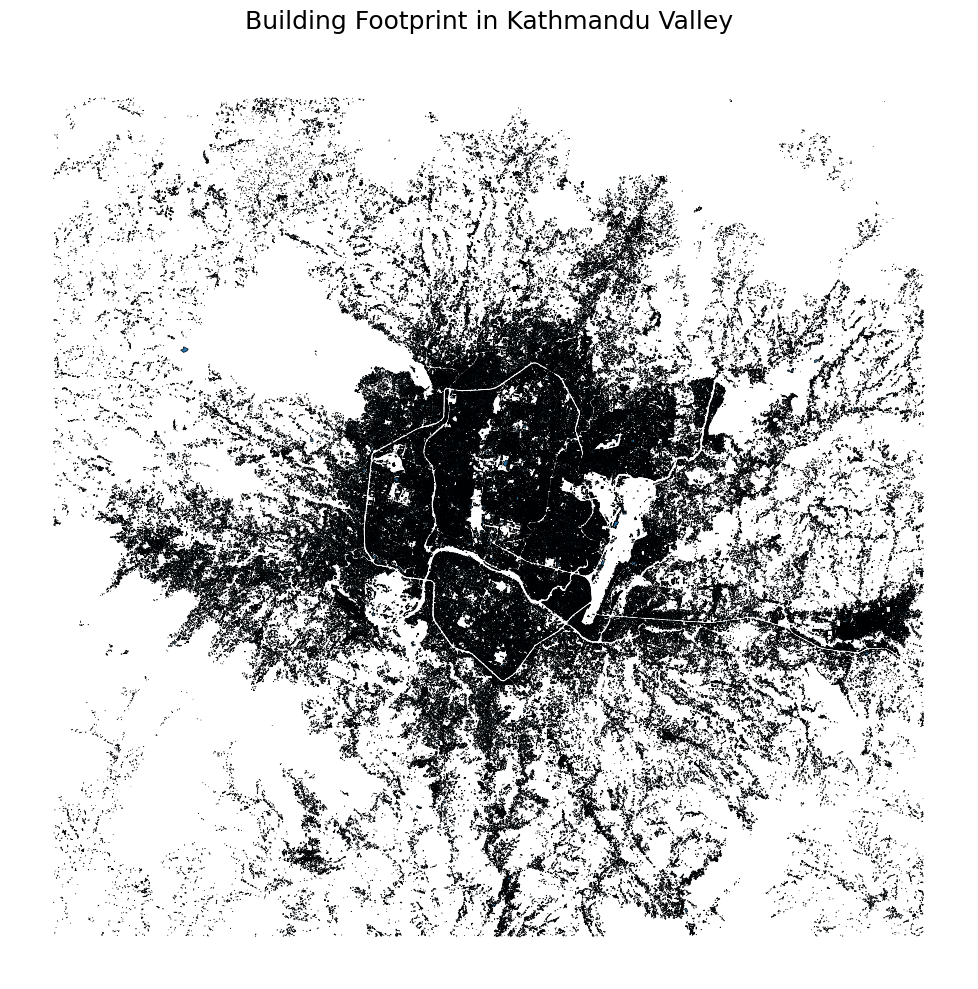

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('ivory')

plot = buildings_gdf.plot(ax=ax, 
    edgecolor='black',
    linewidth=0.5
)

ax.set_title("Building Footprint in Kathmandu Valley", 
    size=18, 
    pad=20
)
ax.set_axis_off()

plt.tight_layout()

We can see from the map that the dataset contains buildings in distance hill regions as well. We don't want this, so let us clip our dataset to just the boundary. However, before that, we will need to rename some of our columns.

In [ ]:
rename_cols = {}

for col in boundary_gdf.columns:
    if col in buildings_gdf.columns and col != 'geometry':
        rename_cols[col] = f"{col}_boundary"
    
if rename_cols:
    boundary_gdf = boundary_gdf.rename(columns=rename_cols)

In [ ]:
buildings_clipped = gpd.overlay(buildings_gdf, boundary_gdf, how='intersection')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('ivory')

plot = buildings_clipped.plot(ax=ax, 
    edgecolor='black',
    linewidth=0.5
)

ax.set_title("Building Footprint in Kathmandu Valley", 
    size=18, 
    pad=20
)
ax.set_axis_off()

plt.tight_layout()

Finally, let us save our data to a geojson.

In [ ]:
buildings_clipped.to_file("ktm_buildings.geojson", driver="GeoJSON")